# А/Б тест.

### Цель исследования
провести оценку результатов A/B-теста - изменений, связанных с внедрением улучшенной рекомендательной системы.

Оценить происходит ли улучшение следующих метрик (не менее 10%):

конверсии в просмотр карточек товаров — событие product_page,\
просмотры корзины — product_cart,\
покупки — purchase.

### Порядок исследования
перед нами 4 датасета:

ab_project_marketing_events.csv - календарь маркетинговых событий на 2020 год, в котором отражена информация о всех маркетинговых мероприятиях;\
final_ab_new_users.csv - информация о пользователях, зарегистрировавшиеся с 7 по 21 декабря 2020 года;\
final_ab_events.csv - действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;\
final_ab_participants.csv - таблица участников тестов.

О качестве данных ничего не известно, на первоначальном этапе требуется изучить датасет и выполнить предобработку данных,\
выполнив проверку на соответствие наименований столбцов, наличие дубликатов, пропусков, корректность типов данных,\
уникальность значений, убедиться в полноте данных.

После выполнения предобработки необходимо оценить корректность проведения теста и обратить вниание на:
- соответствие данных требованиям технического задания. Проверить корректность всех пунктов технического задания.
- время проведения теста. Убедиться, что оно не совпадает с маркетинговыми и другими активностями.
- аудиторию теста. Удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.\
Проверить равномерность распределения по тестовым группам и правильность их формирования.


Провести исследовательский анализ данных и ответить на следующие вопросы:
- Количество событий на пользователя одинаково распределены в выборках?
- Как число событий в выборках распределено по дням?
- Как меняется конверсия в воронке в выборках на разных этапах?
- Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

Оценить результаты A/B-тестирования и ответить на вопросы:
- Что можно сказать про результаты A/В-тестирования?
- Проверить статистическую разницу долей z-критерием.

И описать выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования.\
Сформулировать общее заключение о корректности проведения теста.

### Техническое задание
Название теста: recommender_system_test;\
группы: А — контрольная, B — новая платёжная воронка;дата запуска: 2020-12-07;\
дата остановки набора новых пользователей: 2020-12-21;\
дата остановки: 2021-01-04;\
аудитория: 15% новых пользователей из региона EU;\
назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;\
ожидаемое количество участников теста: 6000.\
ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:\
конверсии в просмотр карточек товаров — событие product_page,\
просмотры корзины — product_cart,
покупки — purchase.

### Описание данных

ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год.

Структура файла:

name — название маркетингового события;\
regions — регионы, в которых будет проводиться рекламная кампания;\
start_dt — дата начала кампании;\
finish_dt — дата завершения кампании.


final_ab_new_users.csv — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

user_id — идентификатор пользователя;\
first_date — дата регистрации;\
region — регион пользователя;
device — устройство, с которого происходила регистрация.


final_ab_events.csv — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

user_id — идентификатор пользователя;\
event_dt — дата и время покупки;\
event_name — тип события;\
details — дополнительные данные о событии.\
Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.


final_ab_participants.csv — таблица участников тестов.

Структура файла:

user_id — идентификатор пользователя;\
ab_test — название теста;\
group — группа пользователя.

## Загрузка и предобработка данных.

In [1]:
#загрузим библиотеки
import pandas as pd
import numpy as np
import warnings
import math as mth
import datetime as dt
import seaborn as sns
sns.set_style("darkgrid")
import scipy.stats as st
import plotly.express as px
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from datetime import datetime, timedelta
warnings.simplefilter("ignore") 
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
#загрузим данные
try:
   marketing_events, new_users, act_users, participants = (
    pd.read_csv("C:\\Users\\kirio\\OneDrive\\Рабочий стол\\ЯПрактикум\\14.1_АВ_тест\\файлы\\ab_project_marketing_events.csv", sep=','), #маркетинговые мероприятия
    pd.read_csv("C:\\Users\\kirio\\OneDrive\\Рабочий стол\\ЯПрактикум\\14.1_АВ_тест\\файлы\\final_ab_new_users.csv", sep=','), #новые пользователи
    pd.read_csv("C:\\Users\\kirio\\OneDrive\\Рабочий стол\\ЯПрактикум\\14.1_АВ_тест\\файлы\\final_ab_events.csv", sep=','),#действия пользователей
    pd.read_csv("C:\\Users\\kirio\OneDrive\\Рабочий стол\\ЯПрактикум\\14.1_АВ_тест\\файлы\\final_ab_participants.csv", sep=',')#участники теста
)
except:
   marketing_events, new_users, act_users, participants = (
    pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv', sep=','), #маркетинговые мероприятия
    pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv', sep=','), #новые пользователи
    pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv', sep=','),#действия пользователей
    pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv', sep=',')#участники теста
)

### Изучение датасетов

In [3]:
# создадим функцию get_info для вывода информации о датасетах
def get_info (data):
    data.info(memory_usage='deep')
    display(data.head())
    display(data.describe())
    print('\033[1m' + 'Количество дубликатов' + '\033[1m',data.duplicated().sum())

In [4]:

get_info(marketing_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 4.0 KB


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Single's Day Gift Promo,APAC,2020-05-09,2020-02-07
freq,1,4,1,1


Количество дубликатов 0


In [5]:
#изменим тип данных на формат даты
marketing_events['start_dt']=pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt']=pd.to_datetime(marketing_events['finish_dt'])

In [6]:
get_info(new_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 15.4 MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,194F99D70751F5C2,2020-12-21,EU,Android
freq,1,6290,46270,27520


Количество дубликатов 0


In [7]:
# изменим тип данных на формат даты
new_users['first_date']=pd.to_datetime(new_users['first_date'])

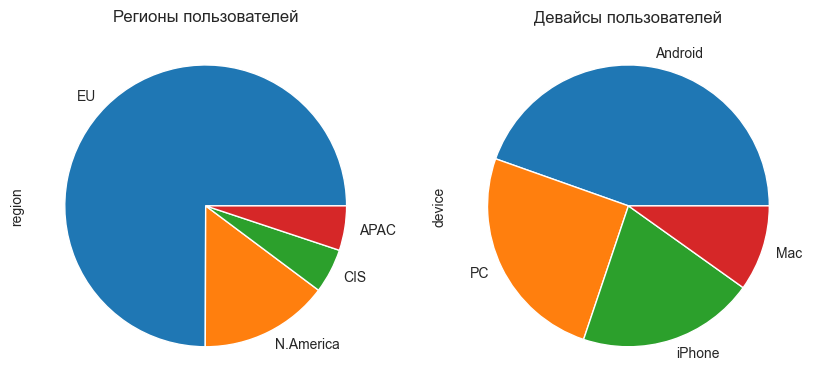

In [8]:
#регионы и девайсы пользователей
fig, axes = plt.subplots(1, 2, figsize=(10,5))

new_users['region'].value_counts().plot(kind='pie',ax=axes[0])
axes[0].set_title('Регионы пользователей')

new_users['device'].value_counts().plot(kind='pie',ax=axes[1])
axes[1].set_title('Девайсы пользователей')

plt.show()

In [9]:
get_info(act_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 93.4 MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,details
count,"62,740.00"
mean,23.88
std,72.18
min,4.99
25%,4.99
50%,4.99
75%,9.99
max,499.99


Количество дубликатов 0


В таблице с действиями пользователей есть пропущенные значения в details. Дубликатов нет.

Изменим тип данных на формат даты.

Изучим пропущенные значения. Предположим details заполнены только для покупок.

In [10]:
#сгруппируем по названию  события и поверим
act_users.pivot_table(index='event_name', values='details', aggfunc='count')

,details
event_name,
login,0
product_cart,0
product_page,0
purchase,62740


В столбце details отражена стоимость товара для  purchase, по остальным этапам воронки  пропущенные значения можно заменить на 0


In [11]:
act_users['details']=act_users['details'].fillna(0)

In [12]:
#изменим тип
act_users['event_dt']=pd.to_datetime(act_users['event_dt'])

In [13]:
get_info(participants)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 3.6 MB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,50CF32FEE0C61DA9,A,interface_eu_test
freq,2,9655,11567


Количество дубликатов 0


Пропущенных значений нет. Формат данных задан верно.\
Проверим значания в колонке ab_test.

In [14]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

### Вывод:

Выполнена предобработка данных, изменены типы данных на формат даты. Дубликаты не обнаружены.

Пользователей проживают в следующих регионах:EU, N.America, CIS, APAC      

Девайсы: Android, PC , iPhone, Mac

В таблице act_users обнаружены пропущенные значения по колонке details. Пропуски были по всем этапам воронки продаж, кроме purchase.\
Это связано с тем, что в поле details фиксируется стоимость покупки на этапе оплаты товара. Все пропуски были заменены на 0.

Воронка событий состоит из следующих ступеней:

login (авторизация пользователя);
product_page (страница с выбором продуктов);
product_cart (корзина продуктов);
purchase (покупка).

В таблице participants отражена информация о принадлежности пользователя к группе теста.\

Тестирование проводится по 2 группам:

interface_eu_test           - 11567\
recommender_system_test     - 6701


## Соответствие техническому заданию (ТЗ)

### Объединие таблиц

In [15]:
#Объединим информацию в таблицу data из 3 таблиц: action, new_users, participants
data = pd.merge(act_users, new_users, on='user_id', how='left')
data = pd.merge(data, participants, on='user_id', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446211 entries, 0 to 446210
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     446211 non-null  object        
 1   event_dt    446211 non-null  datetime64[ns]
 2   event_name  446211 non-null  object        
 3   details     446211 non-null  float64       
 4   first_date  446211 non-null  datetime64[ns]
 5   region      446211 non-null  object        
 6   device      446211 non-null  object        
 7   group       106625 non-null  object        
 8   ab_test     106625 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 34.0+ MB


In [16]:
#проверим даты событий.
print("Минимальная дата события: {}".format(data['event_dt'].min()))
print("Максимальная дата события: {}".format(data['event_dt'].max()))

Минимальная дата события: 2020-12-07 00:00:33
Максимальная дата события: 2020-12-30 23:36:33


Максимальная дата события не соответствует ТЗ, за дату остановки тестирования следует принять: 2020-12-30

### Распределение пользователей

In [17]:
#создадим таблицу slip с пользователями, которые попали в 2 теста или в 2 группы
slip = data.pivot_table(index=['user_id'], values=['group','ab_test'], aggfunc='nunique')\
    .query('ab_test>1 or group>1')\
    .reset_index()
display(slip ) 
slip = slip['user_id']

,user_id,ab_test,group
0,001064FEAAB631A1,2,1
1,00341D8401F0F665,2,1
2,0082295A41A867B5,2,2
3,00E68F103C66C1F7,2,2
4,00EFA157F7B6E1C4,2,1
...,...,...,...
882,FEA0C585A53E7027,2,2
883,FEC0BCA6C323872F,2,2
884,FF2174A1AA0EAD20,2,1
885,FF44696E39039D29,2,1


In [18]:
#Выведем информацию по пользователю, участвующего в 2х тестах и группах
data.query('user_id=="0082295A41A867B5"').head()

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
24036,0082295A41A867B5,2020-12-16 07:06:32,purchase,4.99,2020-12-16,EU,iPhone,A,recommender_system_test
24037,0082295A41A867B5,2020-12-16 07:06:32,purchase,4.99,2020-12-16,EU,iPhone,B,interface_eu_test
26389,0082295A41A867B5,2020-12-17 16:04:53,purchase,4.99,2020-12-16,EU,iPhone,A,recommender_system_test
26390,0082295A41A867B5,2020-12-17 16:04:53,purchase,4.99,2020-12-16,EU,iPhone,B,interface_eu_test
29203,0082295A41A867B5,2020-12-18 02:28:55,purchase,4.99,2020-12-16,EU,iPhone,A,recommender_system_test


887 пользователей попали в 2 группы тестирования, есть риск искажения данных,\
так как нельзя однозначно интерпретировать какое изменения повлияло на поведение пользователя.

In [19]:
#Удалим пользователей, которые попали в 2 группы тестирования и interface_eu_test
data_cut = data.query('user_id not in@slip & ab_test !="interface_eu_test"')
#удалено:
print(
    "Отфильтровано: {:.2%} данных."
    .format(round((len(data)-len(data_cut))/len(data),4))
)

Отфильтровано: 19.68% данных.


In [20]:
#Проверим пользователей, по которым не указана информация о группе к которым они относятся.
data_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358390 entries, 0 to 446210
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     358390 non-null  object        
 1   event_dt    358390 non-null  datetime64[ns]
 2   event_name  358390 non-null  object        
 3   details     358390 non-null  float64       
 4   first_date  358390 non-null  datetime64[ns]
 5   region      358390 non-null  object        
 6   device      358390 non-null  object        
 7   group       18804 non-null   object        
 8   ab_test     18804 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 27.3+ MB


In [21]:
#создадим список с пользователями у которых не указана группа.
no_group = data_cut.query('group.isna()==True')['user_id']
#делаем срез, выведем % удаления
data_cut_1 = data_cut.query('user_id not in@no_group')
print(
    "Отфильтровано, без группы тестирования: {:.2%} данных."
    .format(round((len(data_cut)-len(data_cut_1))/len(data_cut),4))
)

Отфильтровано, без группы тестирования: 94.75% данных.


In [22]:
#минимальная и максимальная дата появления нового пользователя
print("Минимальная дата: {}".format(data_cut_1['first_date'].min()))
print("Максимальная дата: {}".format(data_cut_1['first_date'].max()))

Минимальная дата: 2020-12-07 00:00:00
Максимальная дата: 2020-12-21 00:00:00


По очищенным данным минимальная и максимальная даты набора новых пользователей соответствуют условиям ТЗ (2020-12-07 - 2020-12-21)

### Пересечение с маркетинговыми мероприятиями

In [23]:
display(marketing_events.query('start_dt>"2020-12-06" and start_dt<"2020-12-31"'))

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Есть пересечение с проведением мероприятия "Christmas&New Year Promo".\
Что повлияет на качество пользователей, но на относительную конверсию, группы В к группе А, не будет иметь воздействие

### Регион EU, 15%.

Посчитаем долю пользователей, которые участвовали в тесте из Евросоюза, от общего числа пользователей из этого региона,\
которые были зарегистрированы на ресурсе в период с 07 по 21 декабря включительно.

In [24]:
new_users = new_users.query('first_date >= "2020-12-07" & first_date <= "2020-12-21"')

users = new_users.merge(
    participants, on='user_id', how='left'
).dropna()

recommender_system_test_users = users[users['ab_test'] == 'recommender_system_test']

#посчитаем долю участников из региона EU
print(
    'Доля участников теста относительно общего количества новых пользователей из региона "Европа": {:.2f}%'.format(
        len(recommender_system_test_users)/len(new_users[new_users['region'] == 'EU'])*100)
)

Доля участников теста относительно общего количества новых пользователей из региона "Европа": 15.83%


15.83% - доля пользователей, которые участвовали в тесте из Евросоюза, от общего числа пользователей из этого региона,\
которые были зарегистрированы на ресурсе в период с 07 по 21 декабря включительно.

<div class="alert alert-info"> <b>Комментарии студента:</b> Исправил, и что же я сразу не сделал </div>

In [25]:
#создадим таблицу, в которой отобразим информацию по тестированию recommender_system_test.
data_group_by_test_recommender=(
    data_cut_1
    .pivot_table(index=['region','group'],values='user_id',aggfunc='nunique')
    .reset_index()
)

display(data_group_by_test_recommender)

print(
    'Общее количество участников: {:,}.'
    .format(data_group_by_test_recommender['user_id'].sum())
)
print()
print(
    'Общее количество участников из Европы: {:,}.'
    .format(data_group_by_test_recommender.query('region=="EU"')['user_id'].sum())
)
print()
print(
    'Общее количество участников группы А: {:,}.'
    .format(data_group_by_test_recommender.query('group=="A"')['user_id'].sum())
)
print()
print(
    'Общее количество участников группы B: {:,}.'
    .format(data_group_by_test_recommender.query('group=="B"')['user_id'].sum())
)



,region,group,user_id
0,APAC,A,28
1,APAC,B,17
2,CIS,A,19
3,CIS,B,11
4,EU,A,1939
5,EU,B,655
6,N.America,A,96
7,N.America,B,23


Общее количество участников: 2,788.

Общее количество участников из Европы: 2,594.

Общее количество участников группы А: 2,082.

Общее количество участников группы B: 706.


In [26]:
print(
    'В результате проверки на соответствие ТЗ отфильтровано: {:.2%} данных.'
    .format(round((len(data)-len(data_cut_1))/len(data),4))
)

В результате проверки на соответствие ТЗ отфильтровано: 95.79% данных.


### Вывод:

По условиям ТЗ установлены следующие даты тестирования:

дата запуска: 2020-12-07;\
дата остановки набора новых пользователей: 2020-12-21;\
дата остановки: 2021-01-04;

В выгруженном датасете, после выполенения предобработки был опеределен период данных с 2020-12-07 по 2020-12-30,\
что не соответствует дате остановки, указанной в ТЗ.

При проверке дат проведения маркетинговых мероприятий была выявлено пересечение мероприятия "Christmas&New Year Promo",\
Что повлияет на качество пользователей, но на относительную конверсию, группы В к группе А, не будет иметь воздействие.

Часть пользователей попали в конкурирующие группы тестирования (А и В) и в 2 теста.\
При попадении клиентов в 2 группы одновременно, высок риск искажения данных.\
Неизвестно, что именно повлияло на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.\
Информация по данным пользователям была удалена из датасета.

В датасете отражена информация о 2 тестированиях: recommender_system_test и interface_eu_test.\
Информация о 2м тестировании удалена в соответствии с ТЗ.

Аудитория: 15.83% новых пользователей из региона EU;

Частично соблюдены условия:\
Ожидаемое количество участников теста: 6000 .


## Исследовательский анализ данных (EDA).

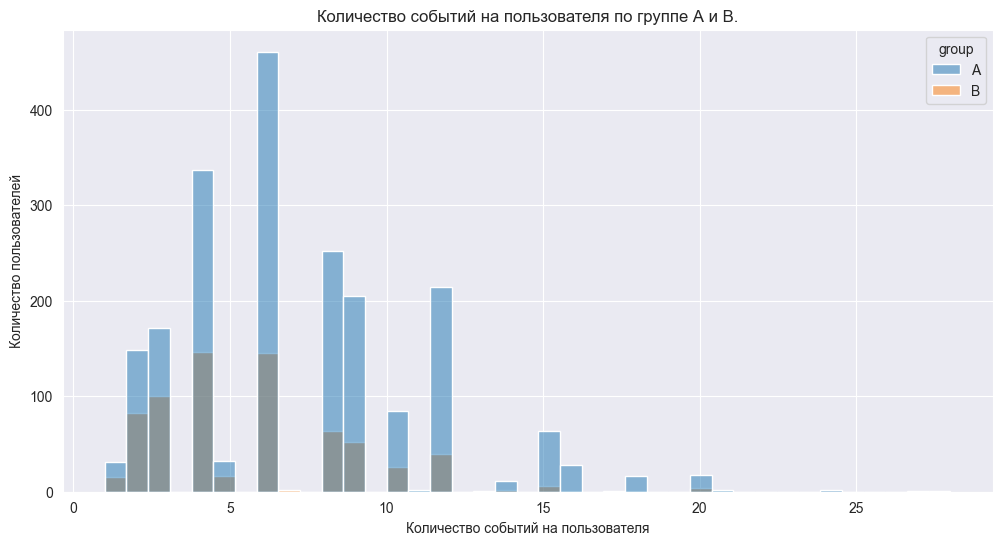

In [27]:
#проверим количество событий на пользователя из группы А и В
data_group_by_user_A = (
    data_cut_1
    .query('group=="A"')
    .pivot_table(index='user_id', values='event_name', aggfunc='count')
    .reset_index()
)

data_group_by_user_B = (
    data_cut_1
    .query('group=="B"')
    .pivot_table(index='user_id', values='event_name', aggfunc='count')
    .reset_index()
)

data_group_by_user = (
    data_cut_1
    .pivot_table(index=['user_id', 'group'], values='event_name', aggfunc='count')
    .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    data=data_group_by_user, x="event_name", hue="group")

plt.grid(True)
plt.xticks(rotation=0)
plt.xlabel("Количество событий на пользователя")
plt.ylabel("Количество пользователей")
plt.title("Количество событий на пользователя по группе А и В.")

plt.show()

Популярное количество событий на пользователя по группе А - 6, группе В - 4.

In [28]:
#посчитаем среднее на одного пользователя
data_group_by_user = data_cut_1.pivot_table\
    (index='user_id', values='event_name', aggfunc='count')
print("Среднее количество событий на пользователя: {:,.0f} ".format(data_group_by_user['event_name'].mean()))

Среднее количество событий на пользователя: 7 


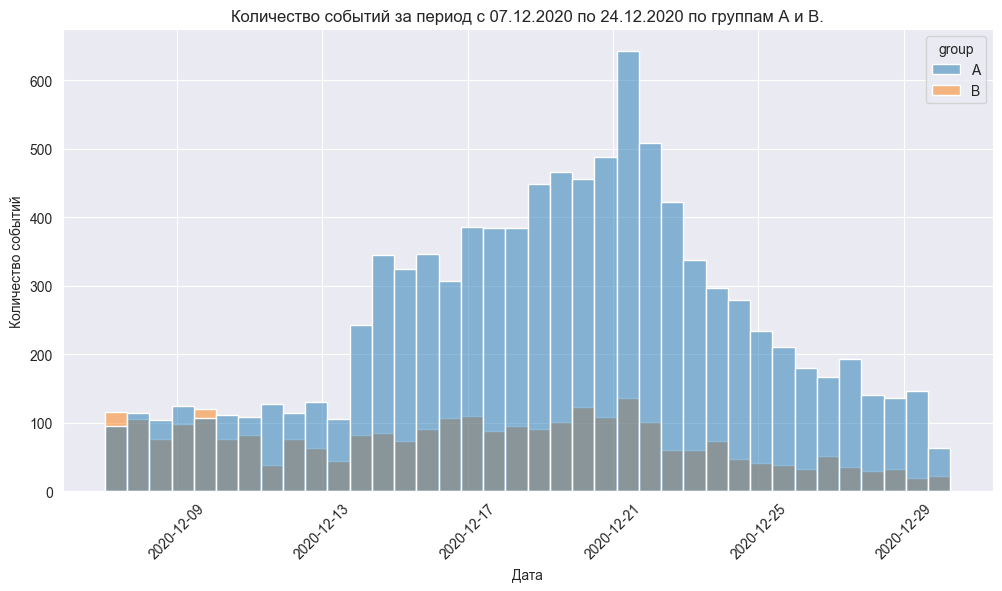

In [29]:
#количество событий на пользователя по дням по каждой группе пользователей
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    data=data_cut_1
    .pivot_table(index=['event_dt', 'group'], values='event_name', aggfunc='count')
    .reset_index(), x="event_dt", hue="group")
plt.grid(True)
plt.xticks(rotation=45)
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.title("Количество событий за период с 07.12.2020 по 24.12.2020 по группам А и B.")
plt.show()

Количество событий по группе В по всему периоду распределено равномерно, по группе А наблюдается резкий скачок по количеству событий 14.12.2020 и 21.12.2020
 

Проверим количество регистраций пользователей совершивших хотя бы одно событие

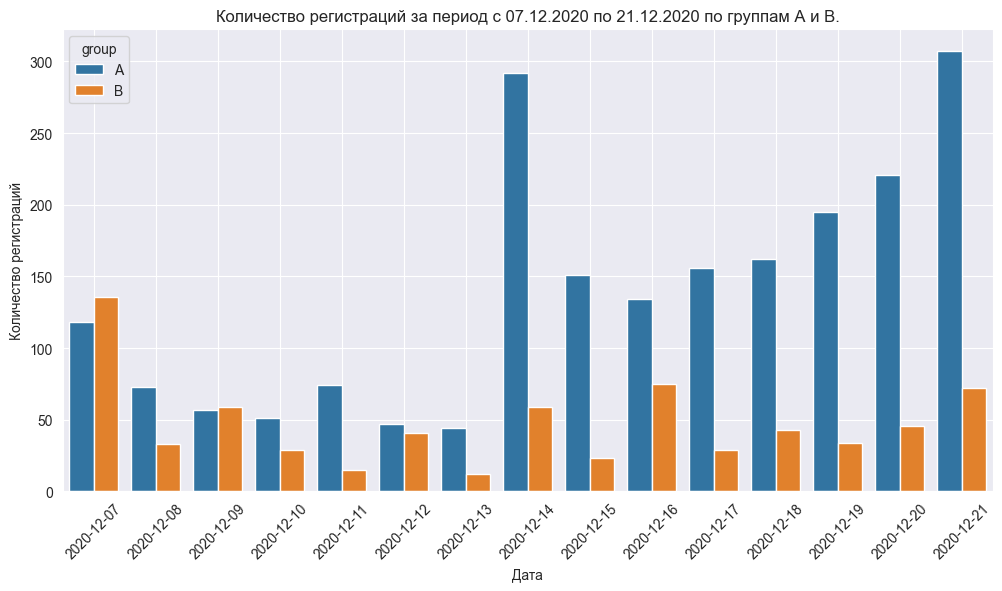

In [30]:
# добавим столбец, где будет указана только дата регистрации (без времени)
data_cut_1['reg_dt'] = data_cut_1['first_date'].dt.date
#количество регистраций на пользователя по дням по каждой группе пользователей
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    data=data_cut_1
    .pivot_table(index=['reg_dt', 'group'], values='user_id', aggfunc='nunique')
    .reset_index(), x="reg_dt", y = 'user_id', hue="group")
plt.grid(True)
plt.xticks(rotation=45)
plt.xlabel("Дата")
plt.ylabel("Количество регистраций")
plt.title("Количество регистраций за период с 07.12.2020 по 21.12.2020 по группам А и B.")
plt.show()

На графике распределения регистраций видим в эти же дни были скачки по числу регистраций пользователей.\
Значит происходил активный набор пользователей в группу А, что повлияло на активность.\
После 21.12.2020 активность в обоих группах снижается, это последний день регистрации новых пользователей.

### Воронка событий

In [31]:
#переименуем датасет в df
df = data_cut_1

Посчитаем сколько пользователей совершили каждое из событий, а также долю пользователей, которые хоть раз совершали событие.

In [32]:
user_group_A = (
    df
    .query('group=="A"')
    .pivot_table(index='event_name', values='user_id', aggfunc={'nunique'})
    .sort_values(by='nunique', ascending=False)
    .reset_index()
)
user_group_A

,event_name,nunique
0,login,2082
1,product_page,1360
2,purchase,652
3,product_cart,631


In [33]:
user_group_B = (
    df
    .query('group=="B"')
    .pivot_table(index='event_name', values='user_id', aggfunc={'nunique'})
    .sort_values(by='nunique', ascending=False)
    .reset_index()
)
user_group_B

,event_name,nunique
0,login,706
1,product_page,397
2,purchase,198
3,product_cart,195


In [34]:
#изменим последовательность строк по порядку действий пользователя
user_group_A = user_group_A.copy()
user_group_A.iloc[2,:],user_group_A.iloc[3,:]=user_group_A.iloc[3,:],user_group_A.iloc[2,:]

user_group_B = user_group_B.copy()
user_group_B.iloc[2,:], user_group_B.iloc[3,:] = user_group_B.iloc[3,:],user_group_B.iloc[2,:]

In [35]:
#добавим % перехода
user_group_A['%'] = user_group_A['nunique']/len(df.query('group=="A"')['user_id'].unique())*100
user_group_A

,event_name,nunique,%
0,login,2082,100.00
1,product_page,1360,65.32
2,product_cart,631,30.31
3,purchase,652,31.32


In [36]:
user_group_B['%'] = user_group_B['nunique']/len(df.query('group=="B"')['user_id'].unique())*100
user_group_B

,event_name,nunique,%
0,login,706,100.00
1,product_page,397,56.23
2,product_cart,195,27.62
3,purchase,198,28.05


Количество покупок превышает корзину - часть пользователей переходят к оплате минуя корзину.

In [37]:
#построим воронку по группе А
fig = go.Figure(
    go.Funnel(y=user_group_A['event_name'], x= user_group_A['nunique'])
                 )
fig.update_layout(title_text='Воронка событий по группе А')
fig.show()

In [38]:
#построим воронку по группе В
fig = go.Figure(
    go.Funnel(y=user_group_B['event_name'], x= user_group_B['nunique'])
                 )
fig.update_layout(title_text='Воронка событий по группе B')
fig.show()

### Конверсия

In [39]:
#рассчитаем конверсию по группе А
user_group_A['users_funnel']  = (user_group_A['nunique'] / user_group_A['nunique'].shift())*100
user_group_A['users_funnel']=user_group_A['users_funnel'].fillna(0)
user_group_A['plus_10']=user_group_A['users_funnel']*0.1+user_group_A['users_funnel']
user_group_A['total'] = (
    user_group_A['nunique'] / user_group_A
    .query('event_name=="login"')['nunique'].sum()*100
)
#рассчитаем конверсию по группе В
user_group_B['users_funnel']  = (user_group_B['nunique'] / user_group_B['nunique'].shift())*100
user_group_B['users_funnel']=user_group_B['users_funnel'].fillna(0)
user_group_B['total'] = (
    user_group_B['nunique'] / user_group_B
    .query('event_name=="login"')['nunique'].sum()*100
)

In [40]:
display(user_group_A)
user_group_B

,event_name,nunique,%,users_funnel,plus_10,total
0,login,2082,100.00,0.00,0.00,100.00
1,product_page,1360,65.32,65.32,71.85,65.32
2,product_cart,631,30.31,46.40,51.04,30.31
3,purchase,652,31.32,103.33,113.66,31.32


,event_name,nunique,%,users_funnel,total
0,login,706,100.00,0.00,100.00
1,product_page,397,56.23,56.23,56.23
2,product_cart,195,27.62,49.12,27.62
3,purchase,198,28.05,101.54,28.05


Ожидаемый эффект от тестирования не был достигнут, показатели конверсии в просмотр карточек товаров — событие product_page,\
просмотры корзины — product_cart, покупки — purchase не только не увеличились на 10%, а стали ниже.

### Вывод

Среднее количество событий на пользователя - 6.\
Самое популярное количество событий на пользователя по группе А - 6, по группе В - 4.

Количество событий по группе B распределено более равномерно по всему периоду,\
по группе А наблюдается резкий скачок по количеству событий 14 и 21 декабря.\
В эти дни роисходил активный набор пользователей в группу А, что повлияло на активность.\
После 21.12.2020 активность в обоих группах снижается, это последний день регистрации новых пользователей.

Основная часть пользователей по группе А теряется после авторизации,\
лишь 65,32% пользователей переходит на страницу с предложением о покупке.\
От первого события до оплаты доходит лишь 31.32% пользователей.

По группе пользователей В после авторизации к предложениям о покупке переходит 56.31% пользователей,\
и меньшее количество пользователей приобретает товар 28.09%.

Следовательно можно сделать предположение: новые рекомендации и интерфейс работают неэффективно,\
так как количество переходов на страницу с предложением о покупоке уменьшилось,\
снизилось количество покупок без перехода в корзину и само количество покупок (с 31,32% до 28.09%).


## Анализ результатов А/В-теста

In [41]:
#количество пользователей в каждой экспериментальной группе
df.pivot_table(index='group', values='user_id', aggfunc={'nunique'})\
    .sort_values(by='nunique', ascending=False)

,nunique
group,
A,2082
B,706


Проверим находят ли статистические критерии разницу между выборками A и B по событиям.

In [42]:
df.pivot_table(index='event_name', columns='group', values='user_id', aggfunc=['nunique'])

nunique     
group              A    B
event_name               
login           2082  706
product_cart     631  195
product_page    1360  397
purchase         652  198

In [43]:
def z_test(query1, query2, event):
        
        ev1 = df.query(query1)['user_id'].nunique()
        ev2 = df.query(query2)['user_id'].nunique()
        us1 = df.query('group=="A"')['user_id'].nunique()           
        us2 = df.query('group=="B"')['user_id'].nunique()
        alpha = 0.05/4 # критический уровень статистической значимости с применением метода Бонферони,
        #4 события, сравнения внутри группы и между групп = 1*4 = 4 события
        
        #проверяем гипотезы для первой пары значений
        ev = np.array([ev1, ev2])
        us = np.array([us1, us2])   
        
        # пропорция успехов в первой группе:
        p1 = ev[0]/us[0]
        # пропорция успехов во второй группе:
        p2 = ev[1]/us[1]
        
        print(ev[0], ev[1],us[0] , us[1])
        # пропорция успехов в комбинированном датасете:
        p_combined = (
            (ev[0] + ev[1]) /
            (us[0] + us[1])
        )
        #разница пропорций в датасетах
        difference = p1 - p2

        #считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = (
            difference / mth
            .sqrt(p_combined * (1 - p_combined)
            * (1/us[0] + 1/us[1]))
        )
        #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p-значение: {:,.8f}'.format(p_value))
        if (p_value < alpha):
            print(
                ("Отвергаем нулевую гипотезу: между долями групп А и В по событию {} есть значимая разница"
                 .format(event))
            )
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп А и В по событию {} разными"
                  .format(event))
                    

Применим функцию к контрольным группам A/B по каждому событию. Проверим гипотезы:

H0 - Доли пользователей в каждой группе равны.\
H1 - Доли пользователей в каждой группе не равны.

In [44]:
z_test('group == "A" and event_name == "login"','group == "B" and event_name == "login"',"login")

2082 706 2082 706
p-значение: nan
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп А и В по событию login разными


In [45]:
z_test('group == "A" and event_name == "product_page"','group == "B" and event_name == "product_page"',"product_page")

1360 397 2082 706
p-значение: 0.00001537
Отвергаем нулевую гипотезу: между долями групп А и В по событию product_page есть значимая разница


In [46]:
z_test('group == "A" and event_name == "product_cart"','group == "B" and event_name == "product_cart"',"product_cart",)

631 195 2082 706
p-значение: 0.17663374
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп А и В по событию product_cart разными


In [47]:
z_test('group == "A" and event_name == "purchase"','group == "B" and event_name == "purchase"',"purchase")

652 198 2082 706
p-значение: 0.10281768
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп А и В по событию purchase разными


### Вывод:

Количество уникальных пользователей по каждой выборке:

In [48]:
df.pivot_table(index='group', values='user_id', aggfunc={'nunique'})\
    .sort_values(by='nunique', ascending=False)

,nunique
group,
A,2082
B,706


В рамках исследования были сформулированы 2 гипотезы о наличии статистически значимых различий по доле пользователей по группам А/В по событиям:

H0 - Доли пользователей по сбытиям в каждой группе равны.\
H1 - Доли пользователей по сбытиям в каждой группе не равны.

При установке критического уровеня статистической значимости был применен метод Бонферони с поправкой в связи со множественными проверками.\
По результатам проверки нулевая гипотеза по событию product_page была отвергнута, так как между долями групп есть значимая разница.\
По остальным событиям гипотезы не были отвергунты и нет оснований считать доли групп А и В разными.\
По результатам ожем предположить, что добавление рекомендаций окажет влияние на количество пользователей по событию product_page.

## Общий вывод:

Для выполнения А/В тестирования от заказчика была получены 4 датасета:

ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год.\
final_ab_new_users.csv — информация о пользователях, зарегистрировавшиеся с 7 по 21 декабря 2020 года,\
следующим регионам: - EU; - N.America; - APAC; - CIS.

final_ab_events.csv — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.\
final_ab_participants.csv — таблица участников тестов.

А также,техническое задание:

Название теста: recommender_system_test;\
группы: А — контрольная, B — новая платёжная воронка;\
дата запуска: 2020-12-07;\
дата остановки набора новых пользователей: 2020-12-21;\
дата остановки: 2021-01-04;\
аудитория: 15% новых пользователей из региона EU;\
назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;\
ожидаемое количество участников теста: 6000.\
ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:\
конверсии в просмотр карточек товаров — событие product_page, просмотры корзины — product_cart, покупки — purchase.

При проверке данных на предмет соответсвия техническому заданию заказчика были выявлены следующие несоответствия:

Название теста: recommender_system_test\
Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;\
В анализируемый период тестировались 2 изменения: recommender_system_test и interface_eu_test.\
Проведение сразу 2 изменений влияет на уровень статистической значимости и данная особенность была учтена при проведении А/В тестирования.\

Группы: А — контрольная, B — новая платёжная воронка;\
Часть пользователей попали в 2 тестовые группы.\
При изучении распределения пользователей по группам было обнаружено, что часть пользователей попали в конкурирующие группы тестирования (А и В).\
При попадении Клиента в группу А и группу B одновременно, есть риск искажения данных. Если пользователь видит разные версии исследуемой страницы\
в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит и результаты такого теста нельзя интерпретировать однозначно.\
Информация по данным вышеуказанным пользователям была удалена из датасета.

В выгруженном датасете, после выполенения предобработки был опеределен период данных с 2020-12-07 по 2020-12-30, что не соответствовало дате остановки,\
указанной в ТЗ. При проверке дат проведения маркетинговых мероприятий было выявлено пересечение с мероприятием "Christmas&New Year Promo",\
таким образом дата остановки тестирования изменена на: 2020-12-24

Аудитория: 15.83% новых пользователей из региона EU,  в тестировании в основном принимают участие пользователи из региона EU.

Ожидаемый эффект, за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%, не оправдался.


Самое популярное количество событий на пользователя по группе А равно 6, по группе В равно 4.\
Количество событий по группе B распределено более равномерно по всему периоду,\
по группе А наблюдается резкий скачок по количеству событий 14 и 21 декабря.\
В эти дни роисходил активный набор пользователей в группу А, что повлияло на активность.\
После 21.12.2020 активность в обоих группах снижается, это последний день регистрации новых пользователей.

Пользователи распределны по группам неравномерно, количество пользователей группы А составило 75% выборки, а пользователи группы В 25%.

При сравнении конверсии по группе А и В можно отметить, что ожидаемый эффект улучшения не менее 10% не был достигнут, а стал ниже.

Основная часть пользователей по группе А теряется после авторизации, лишь 65,32% пользователей переходит на страницу с предложением о покупке.\
От первого события до оплаты доходит лишь 31.32% пользователей.

По группе пользователей В после авторизации к предложениям о покупке переходит 56.31% пользователей, и меньшее количество пользователей приобретает товар 28.09%.

Можно сделать предположение,что новые рекомендации и интерфейс работают неэффективно, так как количество переходов на страницу с предложением о покупоке уменьшилось,\
снизилось количество покупок без перехода в корзину и само количество покупок (с 31,32% до 28.09%).

По результатам проверки нулевая гипотеза по событию product_page была отвергнута,так как между долями групп есть значимая разница.\
По остальным событиям гипотезы не были отвергунты и нет оснований считать доли групп А и В разными.\
В связи этим мы можем предположить, что добавление рекомендаций окажет влияние на количество пользователей по событию product_page.


Резюмируя, говорить об успешности теста нельзя, и я бы рекомендовал провести его заново, в более подходящий период времени,\
тщательно подготовить данные для его проведения и реализовать требования технического задания.
